# Evaluation Metrics Analysis

Notebook ini menganalisis metrik evaluasi dari hasil agentic inference.

## Metrik yang dianalisis:
- **String Metrics**: BLEU, Rouge-L, Jaro-Winkler, Jaccard Cypher
- **Output Metrics**: Pass@1, Jaccard Output
- **Composite Metrics**: LLMetric-Q, LLMetric
- **Agentic Metrics**: Iterations, Recovery Rate, First Attempt Success

In [2]:
# Setup
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Load Results

In [3]:
# Load experiment summary
results_dir = project_root / "results"
summary_path = results_dir / "experiment_summary.json"

if summary_path.exists():
    with open(summary_path, "r") as f:
        summary = json.load(f)
    print(f"Loaded results from: {summary['timestamp']}")
    print(f"Configurations: {list(summary['configurations'].keys())}")
else:
    print("No results found. Please run the inference notebook first.")
    summary = None

Loaded results from: 2025-12-30T15:33:39.924275
Configurations: ['Zero-Shot_Full', 'Zero-Shot_Nodes+Paths', 'Zero-Shot_Paths', 'Few-Shot_Full', 'Few-Shot_Nodes+Paths', 'Few-Shot_Paths', 'CoT_Full', 'CoT_Nodes+Paths', 'CoT_Paths']


In [4]:
# Load detailed results for each configuration
detailed_results = {}

if summary:
    for config_name in summary['configurations'].keys():
        csv_path = results_dir / config_name / "agentic_results.csv"
        if csv_path.exists():
            detailed_results[config_name] = pd.read_csv(csv_path)
            print(f"Loaded {len(detailed_results[config_name])} results for {config_name}")

Loaded 10 results for Zero-Shot_Full
Loaded 10 results for Zero-Shot_Nodes+Paths
Loaded 10 results for Zero-Shot_Paths
Loaded 10 results for Few-Shot_Full
Loaded 10 results for Few-Shot_Nodes+Paths
Loaded 10 results for Few-Shot_Paths
Loaded 10 results for CoT_Full
Loaded 10 results for CoT_Nodes+Paths
Loaded 10 results for CoT_Paths


## 2. Summary Statistics

In [5]:
# Create summary DataFrame
if summary:
    rows = []
    for name, config in summary['configurations'].items():
        agentic = config.get('agentic_metrics', {})
        rows.append({
            "Configuration": name,
            "Prompt": config['prompt_type'],
            "Schema": config['schema_format'],
            "Pass@1 (%)": round(config['pass_at_1_rate'], 2),
            "KG Valid (%)": round(config['kg_valid_rate'], 2),
            "Avg BLEU": round(config['avg_bleu'], 4),
            "Avg Rouge-L": round(config['avg_rouge_l_f1'], 4),
            "Avg Jaro-Winkler": round(config['avg_jaro_winkler'], 4),
            "Avg Jaccard Output": round(config['avg_jaccard_output'], 4),
            "LLMetric-Q": round(config['avg_llmetric_q'], 2),
            "LLMetric": round(config['llmetric'], 2),
            "Avg Iterations": round(agentic.get('avg_iterations', 0), 2),
            "Recovery Rate (%)": round(agentic.get('recovery_rate', 0) * 100, 2),
            "First Attempt Success (%)": round(agentic.get('first_attempt_success_rate', 0) * 100, 2),
        })
    
    df_summary = pd.DataFrame(rows)
    df_summary

## 3. Visualizations

/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/2553542947.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(configs, rotation=45, ha='right')


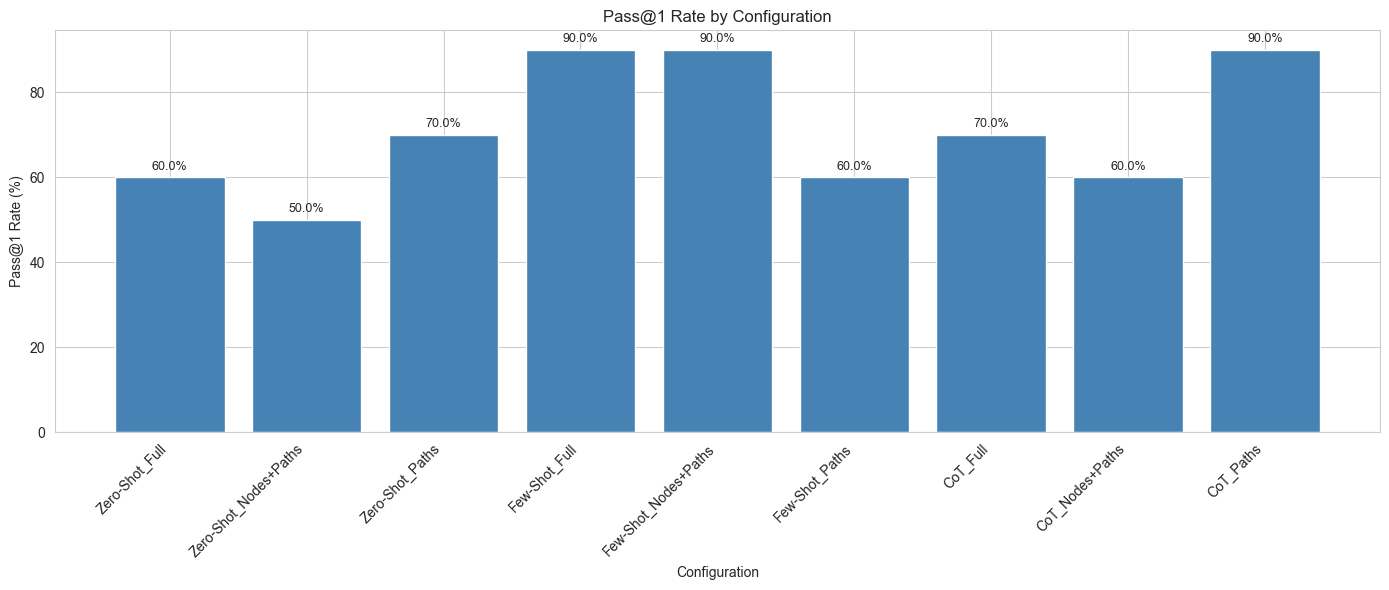

In [6]:
# Pass@1 Rate by Configuration
if summary:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    configs = list(df_summary['Configuration'])
    pass_rates = df_summary['Pass@1 (%)']
    
    bars = ax.bar(configs, pass_rates, color='steelblue')
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Pass@1 Rate (%)')
    ax.set_title('Pass@1 Rate by Configuration')
    ax.set_xticklabels(configs, rotation=45, ha='right')
    
    # Add value labels
    for bar, val in zip(bars, pass_rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'pass_at_1_by_config.png', dpi=150)
    plt.show()

/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/3373034453.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/3373034453.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')


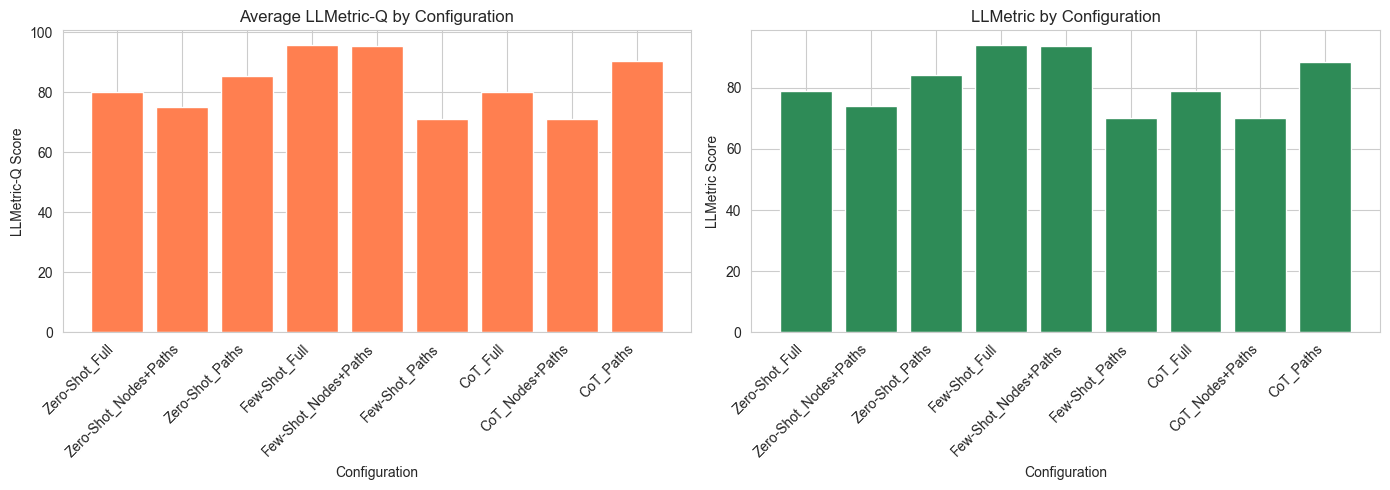

In [7]:
# LLMetric Comparison
if summary:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # LLMetric-Q Distribution
    axes[0].bar(df_summary['Configuration'], df_summary['LLMetric-Q'], color='coral')
    axes[0].set_xlabel('Configuration')
    axes[0].set_ylabel('LLMetric-Q Score')
    axes[0].set_title('Average LLMetric-Q by Configuration')
    axes[0].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
    
    # LLMetric
    axes[1].bar(df_summary['Configuration'], df_summary['LLMetric'], color='seagreen')
    axes[1].set_xlabel('Configuration')
    axes[1].set_ylabel('LLMetric Score')
    axes[1].set_title('LLMetric by Configuration')
    axes[1].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(results_dir / 'llmetric_comparison.png', dpi=150)
    plt.show()

/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/2950396190.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/2950396190.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
/var/folders/nq/tcvdw4t54zzf8cvg6sgv8r6m0000gn/T/ipykernel_48934/2950396190.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')


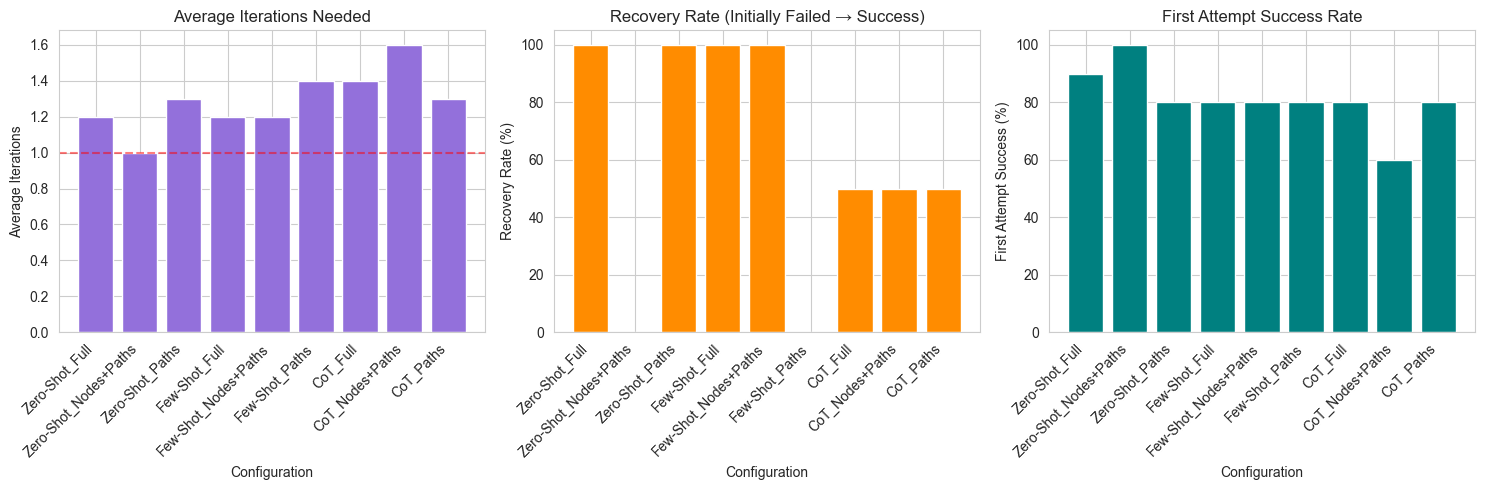

In [8]:
# Agentic Metrics: Iterations and Recovery
if summary:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Average Iterations
    axes[0].bar(df_summary['Configuration'], df_summary['Avg Iterations'], color='mediumpurple')
    axes[0].set_xlabel('Configuration')
    axes[0].set_ylabel('Average Iterations')
    axes[0].set_title('Average Iterations Needed')
    axes[0].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
    axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Single attempt')
    
    # Recovery Rate
    axes[1].bar(df_summary['Configuration'], df_summary['Recovery Rate (%)'], color='darkorange')
    axes[1].set_xlabel('Configuration')
    axes[1].set_ylabel('Recovery Rate (%)')
    axes[1].set_title('Recovery Rate (Initially Failed → Success)')
    axes[1].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
    
    # First Attempt Success
    axes[2].bar(df_summary['Configuration'], df_summary['First Attempt Success (%)'], color='teal')
    axes[2].set_xlabel('Configuration')
    axes[2].set_ylabel('First Attempt Success (%)')
    axes[2].set_title('First Attempt Success Rate')
    axes[2].set_xticklabels(df_summary['Configuration'], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(results_dir / 'agentic_metrics.png', dpi=150)
    plt.show()

## 4. Per-Question Analysis

In [9]:
# Analyze by complexity level
if detailed_results:
    config_name = list(detailed_results.keys())[0]  # Take first config
    df = detailed_results[config_name]
    
    complexity_stats = df.groupby('complexity').agg({
        'success': 'mean',
        'pass_at_1': 'mean',
        'total_iterations': 'mean',
        'llmetric_q': 'mean'
    }).round(4)
    
    complexity_stats.columns = ['Success Rate', 'Pass@1 Rate', 'Avg Iterations', 'Avg LLMetric-Q']
    print(f"\nAnalysis by Complexity Level ({config_name}):")
    complexity_stats


Analysis by Complexity Level (Zero-Shot_Full):


In [10]:
# Analyze by reasoning level
if detailed_results:
    reasoning_stats = df.groupby('reasoning_level').agg({
        'success': 'mean',
        'pass_at_1': 'mean',
        'total_iterations': 'mean',
        'llmetric_q': 'mean'
    }).round(4)
    
    reasoning_stats.columns = ['Success Rate', 'Pass@1 Rate', 'Avg Iterations', 'Avg LLMetric-Q']
    print(f"\nAnalysis by Reasoning Level ({config_name}):")
    reasoning_stats


Analysis by Reasoning Level (Zero-Shot_Full):


## 5. Error Analysis

In [11]:
# Error type distribution
if summary:
    for config_name, config in summary['configurations'].items():
        agentic = config.get('agentic_metrics', {})
        error_dist = agentic.get('error_type_distribution', {})
        
        if error_dist:
            print(f"\n{config_name} - Error Distribution:")
            for error_type, count in error_dist.items():
                print(f"  {error_type}: {count}")


Zero-Shot_Full - Error Distribution:
  syntax_error: 2

Zero-Shot_Paths - Error Distribution:
  syntax_error: 3

Few-Shot_Full - Error Distribution:
  syntax_error: 2

Few-Shot_Nodes+Paths - Error Distribution:
  syntax_error: 2

Few-Shot_Paths - Error Distribution:
  syntax_error: 6

CoT_Full - Error Distribution:
  syntax_error: 5

CoT_Nodes+Paths - Error Distribution:
  syntax_error: 8

CoT_Paths - Error Distribution:
  syntax_error: 4


In [ ]:
# Recovery rate by error type
if summary:
    for config_name, config in summary['configurations'].items():
        agentic = config.get('agentic_metrics', {})
        recovery_by_type = agentic.get('error_recovery_by_type', {})
        
        if recovery_by_type:
            print(f"\n{config_name} - Recovery Rate by Error Type:")
            for error_type, rate in recovery_by_type.items():
                print(f"  {error_type}: {rate*100:.1f}%")

## 6. Export Summary

In [12]:
# Export summary to CSV
if summary:
    export_path = results_dir / 'metrics_summary.csv'
    df_summary.to_csv(export_path, index=False)
    print(f"Exported summary to: {export_path}")

Exported summary to: /Users/tsimiscouse/Docs/Sarjana/Skripsi/kg-luthfi/agentic/results/metrics_summary.csv
